# CLEANING: Predicting Dengue Cases in San Juan, Puerto Rico and Iquitos, Peru

Competition Description:

https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# features

df = pd.read_csv('datasets/dengue_features_train.csv', parse_dates=[3])
# df.head()

In [3]:
# target

target = pd.read_csv('datasets/dengue_labels_train.csv')
# target.head()

## Clean

1. Split data into seperate cities because we don't want imputation from one city's data into another.
2. Find what data is missing in each city.
3. Impute something into those missing data cells. Because the data is time-dependent, imputation will be done with respect to closest available data by date.

In [4]:
# target data is all there
# target.isnull().sum()

In [5]:
# create new datasets

df_sj = df[df['city'] == 'sj']
df_iq = df[df['city'] == 'iq']

In [6]:
# see which features have missing values
# df_sj.isnull().sum()

In [7]:
# see which features have missing values
# df_iq.isnull().sum()

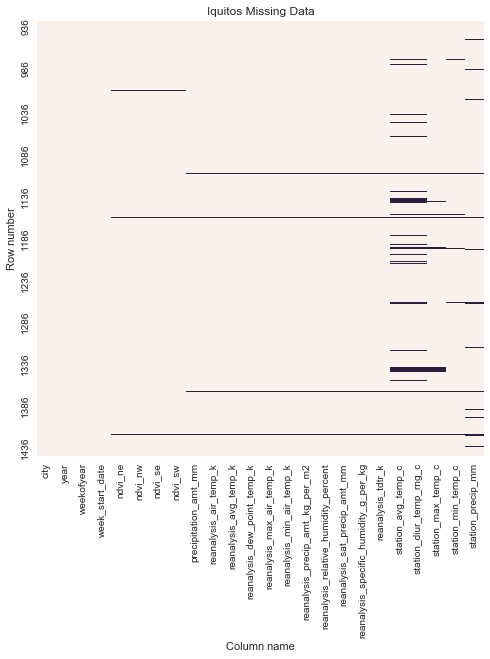

In [8]:
# viz missing data

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_iq.isnull(),ax=ax, cbar = False, yticklabels = 50)

plt.ylabel("Row number")
plt.xlabel("Column name")
plt.title("Iquitos Missing Data")

Here, we can see `station_avg_temp_C` and `station_diur_temp_rng_c` both tend to be missing on the same observation. Also, there are a few observations where the entire row of measurements (not including dates) are missing, and a few where only the weather measurements are gone.

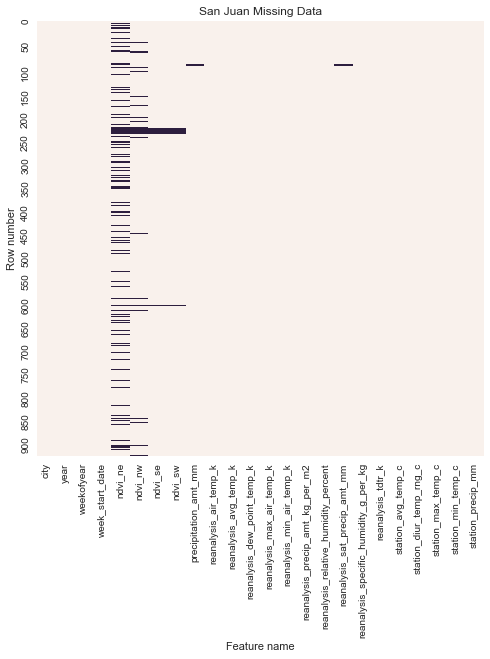

In [9]:
# viz missing data

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_sj.isnull(),ax=ax, cbar = False, yticklabels = 50)

plt.ylabel("Row number")
plt.xlabel("Feature name")
plt.title("San Juan Missing Data")

Here, we can see `nvdi_ne` and sometimes `nvdi_nw` are missing. There is a large block around row 225 where all satellite data is missing. However, the San Juan weather data is much more robust than the Iquitos weather data.

In [10]:
## Impute into Missing values

## see: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html
## see: https://pandas.pydata.org/pandas-docs/stable/missing_data.html
## front fill and back fill allows for date-sensitive na fill

df_sj = df_sj.fillna(method = 'ffill')
df_iq = df_iq.fillna(method = 'ffill')

It is important to note a few things. 

First, we do not want to simply drop the data because there is valuable information elsewhere and we need to test our prediction against the actual value when testing out model. Second, time-sensitive models depend on information from days prior. Dropping data would mess with time series models.

Second, we used front fill, which uses the prior observation to impute. As we saw with the missing data visualization, some features had multiple missing values in a row. Taking the front to fill in all of them may be problematic. We could have used backfill, which would take the following observation to impute, but that would pose the same problem. A better method could be to either take the average of the two to impute, or to impute the front for the first missing value and impute the back for the last value and repeat until they are filled.

Modelling will tell which method is best. Future work will use all methods and the best performing imputation will be selected.

## The Target

In [11]:
df = target.set_index(['year', 'weekofyear'])

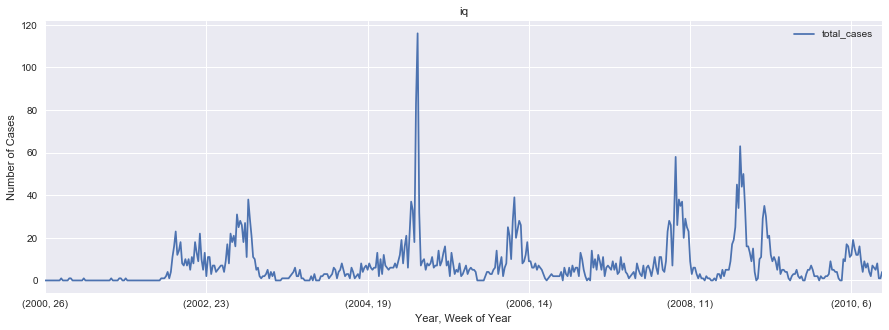

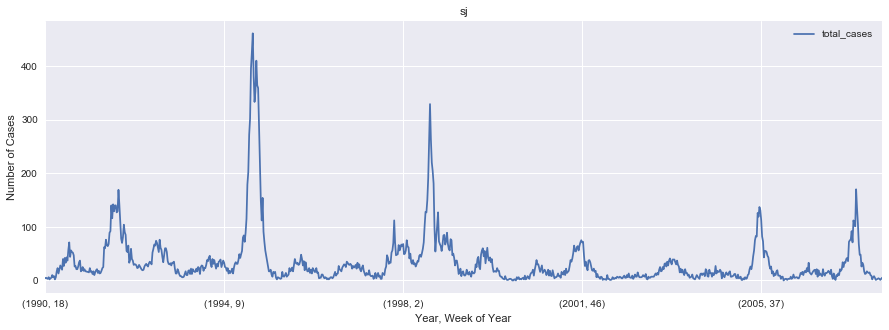

In [12]:
#Plot Cases over time

for i in ['iq', 'sj']:
    data = df[df['city'] == i]
    data.plot(figsize = (15,5))
    plt.title(str(i))
    plt.xlabel("Year, Week of Year")
    plt.ylabel("Number of Cases")
    

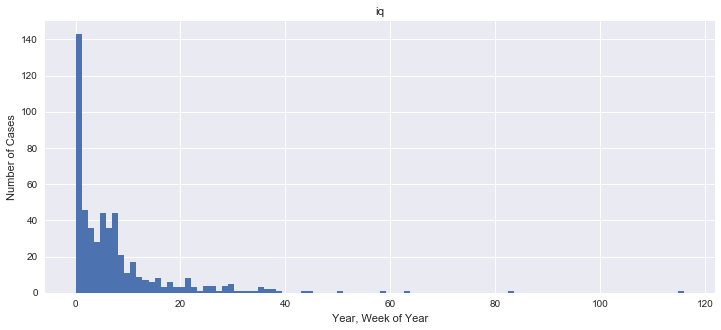

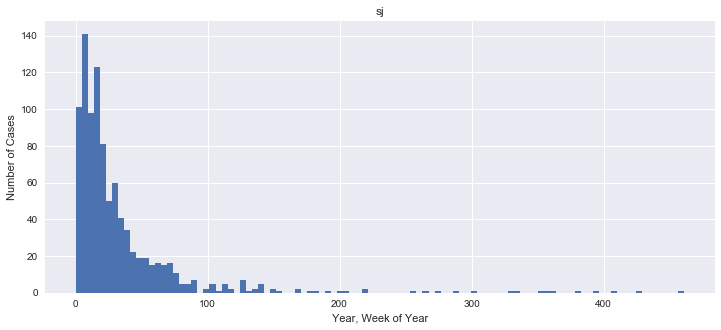

In [104]:
for i in ['iq', 'sj']:
    data = df[df['city'] == i]
    data.hist(bins = 100, figsize = (12,5))
    plt.title(str(i))
    plt.xlabel("Year, Week of Year")
    plt.ylabel("Number of Cases")

A few observations from these two visualizations of Dengue cases both cities:
* The spikes in the time-series are obvious outbreaks. These will be important to predict (for obvious public health reasons) but also because the scoring metric for this competition is Mean Absolute Error. Predicting just the cyclical trend of dengue will throw a large MAE back (although not as large as a Mean Squared Error).
* The cyclical cycle for dengue (peaks and valleys) is more obvious visually in San Juan than Iquitos. This could be due partly to the fact that there are more cases in San Juan than Iquitos (see the y-scale).
* The distribution of cases per week of each year is not normal. Each peak is very close to 0, and Iquitos has many more weeks with 0 cases than any other week. The time-series shows a long period (1990 to ~2001) with 0 or very few cases. Perhaps the features will explain why this period is so different from the 
* High values far to the right are part of the peaks in the cyclical trend or the outbreaks themselves. These rare events will be more difficult to predict.